<a href="https://colab.research.google.com/github/kuds/rl-lunar-lander/blob/main/%5BLunar%20Lander%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization (PPO)
---
In this notebook, you will implement a PPO agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
!pip install swig

In [2]:
!pip install stable_baselines3 gymnasium[box2d]

In [3]:
import gymnasium
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
from stable_baselines3.common.vec_env import VecVideoRecorder

import os
import torch
import numpy
import scipy
import platform
import IPython
import matplotlib
import matplotlib.pyplot
from importlib.metadata import version

In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.10.12
Torch Version: 2.5.0+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 0.29.1
Numpy Version: 1.26.4
Scipy Version: 1.13.1
Swig Version: 4.2.1.post0
Stable Baselines3 Version: 2.3.2
IPython Version: 7.34.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
env = gymnasium.make('LunarLander-v2')
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (8,)
Actions Space:  Discrete(4)


In [6]:
env_str = "LunarLander-v2"
log_dir = "./logs/{}".format(env_str)

In [7]:
#Create Training Environment
env = make_vec_env(env_str, n_envs=1)

#Create Elevation Environment
env_val = make_vec_env(env_str, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20)

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=500_000,
            progress_bar=True,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "ppo_lunar_lander"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

Eval num_timesteps=25000, episode_reward=-953.48 +/- 354.66

Episode length: 411.65 +/- 109.60

New best mean reward!

Eval num_timesteps=50000, episode_reward=-236.36 +/- 64.62

Episode length: 691.60 +/- 258.89

New best mean reward!

Eval num_timesteps=75000, episode_reward=-45.29 +/- 53.09

Episode length: 960.40 +/- 100.32

New best mean reward!

Eval num_timesteps=100000, episode_reward=-29.53 +/- 66.37

Episode length: 864.30 +/- 253.32

New best mean reward!

Eval num_timesteps=125000, episode_reward=17.34 +/- 105.63

Episode length: 743.80 +/- 268.65

New best mean reward!

Eval num_timesteps=150000, episode_reward=87.68 +/- 134.18

Episode length: 527.95 +/- 172.25

New best mean reward!

Eval num_timesteps=175000, episode_reward=25.93 +/- 92.79

Episode length: 857.00 +/- 225.52

Eval num_timesteps=200000, episode_reward=-12.36 +/- 71.38

Episode length: 883.85 +/- 200.39

Eval num_timesteps=225000, episode_reward=130.45 +/- 121.63

Episode length: 361.10 +/- 180.38

New best mean reward!

Eval num_timesteps=250000, episode_reward=154.52 +/- 105.51

Episode length: 480.85 +/- 290.38

New best mean reward!

Eval num_timesteps=275000, episode_reward=192.09 +/- 66.27

Episode length: 429.75 +/- 210.19

New best mean reward!

Eval num_timesteps=300000, episode_reward=182.52 +/- 105.56

Episode length: 400.55 +/- 261.78

Eval num_timesteps=325000, episode_reward=215.47 +/- 76.79

Episode length: 347.00 +/- 224.59

New best mean reward!

Eval num_timesteps=350000, episode_reward=199.61 +/- 94.25

Episode length: 325.65 +/- 172.94

Eval num_timesteps=375000, episode_reward=220.88 +/- 75.23

Episode length: 294.40 +/- 165.53

New best mean reward!

Eval num_timesteps=400000, episode_reward=219.95 +/- 75.96

Episode length: 299.45 +/- 176.20

Eval num_timesteps=425000, episode_reward=222.30 +/- 67.41

Episode length: 437.15 +/- 309.34

New best mean reward!

Eval num_timesteps=450000, episode_reward=191.81 +/- 107.05

Episode length: 298.65 +/- 235.45

Eval num_timesteps=475000, episode_reward=237.79 +/- 74.67

Episode length: 243.80 +/- 39.92

New best mean reward!

Eval num_timesteps=500000, episode_reward=213.42 +/- 104.24

Episode length: 216.65 +/- 39.34

Mean reward: 238.46 +/- 81.83


In [8]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
env = VecVideoRecorder(env, "./videos/",
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_lunar_lander_ppo")

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model - Mean reward: 244.80 +/- 59.68


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_lunar_lander_ppo-step-0-to-step-5000.mp4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


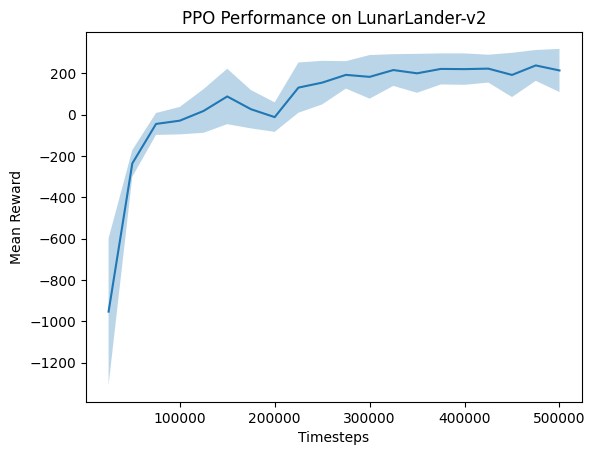

In [9]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"PPO Performance on {env_str}")
matplotlib.pyplot.show()

In [10]:
env = gymnasium.make('LunarLanderContinuous-v2')
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

Observation Space Size:  (8,)
Action Space Size:  (2,)


In [11]:
env_str = "LunarLanderContinuous-v2"
log_dir = "./logs/{}".format(env_str)

In [12]:
#Create Training Environment)
env = make_vec_env(env_str, n_envs=1)

#Create Elevation Environment
env_val = make_vec_env(env_str, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             n_eval_episodes=20)

# Initialize PPO
model = PPO('MlpPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=500_000,
            progress_bar=True,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "ppo_lunar_lander"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

Eval num_timesteps=25000, episode_reward=-154.03 +/- 44.98

Episode length: 159.80 +/- 38.50

New best mean reward!

Eval num_timesteps=50000, episode_reward=-216.27 +/- 115.31

Episode length: 638.10 +/- 249.71

Eval num_timesteps=75000, episode_reward=-2.45 +/- 87.84

Episode length: 976.90 +/- 56.60

New best mean reward!

Eval num_timesteps=100000, episode_reward=147.42 +/- 92.70

Episode length: 516.65 +/- 189.94

New best mean reward!

Eval num_timesteps=125000, episode_reward=158.66 +/- 86.58

Episode length: 493.25 +/- 84.46

New best mean reward!

Eval num_timesteps=150000, episode_reward=134.87 +/- 94.98

Episode length: 606.85 +/- 234.97

Eval num_timesteps=175000, episode_reward=187.61 +/- 75.00

Episode length: 397.15 +/- 80.27

New best mean reward!

Eval num_timesteps=200000, episode_reward=167.83 +/- 113.41

Episode length: 449.40 +/- 164.26

Eval num_timesteps=225000, episode_reward=122.54 +/- 110.10

Episode length: 390.95 +/- 77.18

Eval num_timesteps=250000, episode_reward=150.08 +/- 107.78

Episode length: 370.05 +/- 100.01

Eval num_timesteps=275000, episode_reward=140.57 +/- 120.39

Episode length: 362.85 +/- 69.33

Eval num_timesteps=300000, episode_reward=136.13 +/- 105.70

Episode length: 377.90 +/- 112.75

Eval num_timesteps=325000, episode_reward=186.82 +/- 97.73

Episode length: 339.60 +/- 73.03

Eval num_timesteps=350000, episode_reward=211.26 +/- 75.77

Episode length: 325.95 +/- 46.73

New best mean reward!

Eval num_timesteps=375000, episode_reward=187.41 +/- 101.69

Episode length: 290.85 +/- 61.03

Eval num_timesteps=400000, episode_reward=214.78 +/- 81.59

Episode length: 302.05 +/- 75.88

New best mean reward!

Eval num_timesteps=425000, episode_reward=211.60 +/- 81.94

Episode length: 270.95 +/- 36.21

Eval num_timesteps=450000, episode_reward=182.21 +/- 100.57

Episode length: 306.70 +/- 178.89

Eval num_timesteps=475000, episode_reward=196.15 +/- 90.44

Episode length: 284.30 +/- 95.43

Eval num_timesteps=500000, episode_reward=218.52 +/- 78.83

Episode length: 270.55 +/- 78.94

New best mean reward!

Mean reward: 189.79 +/- 94.58


In [13]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
env = VecVideoRecorder(env, "./videos/",
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_lunar_lander_ppo_con")

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

Best Model - Mean reward: 242.62 +/- 50.25
Moviepy - Building video /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_lunar_lander_ppo_con-step-0-to-step-5000.mp4


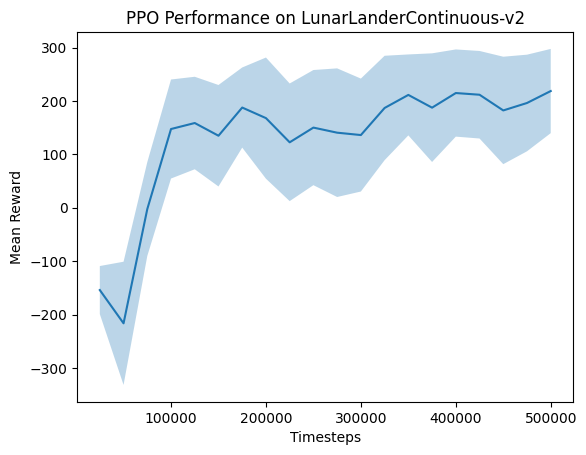

In [14]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"PPO Performance on {env_str}")
matplotlib.pyplot.show()